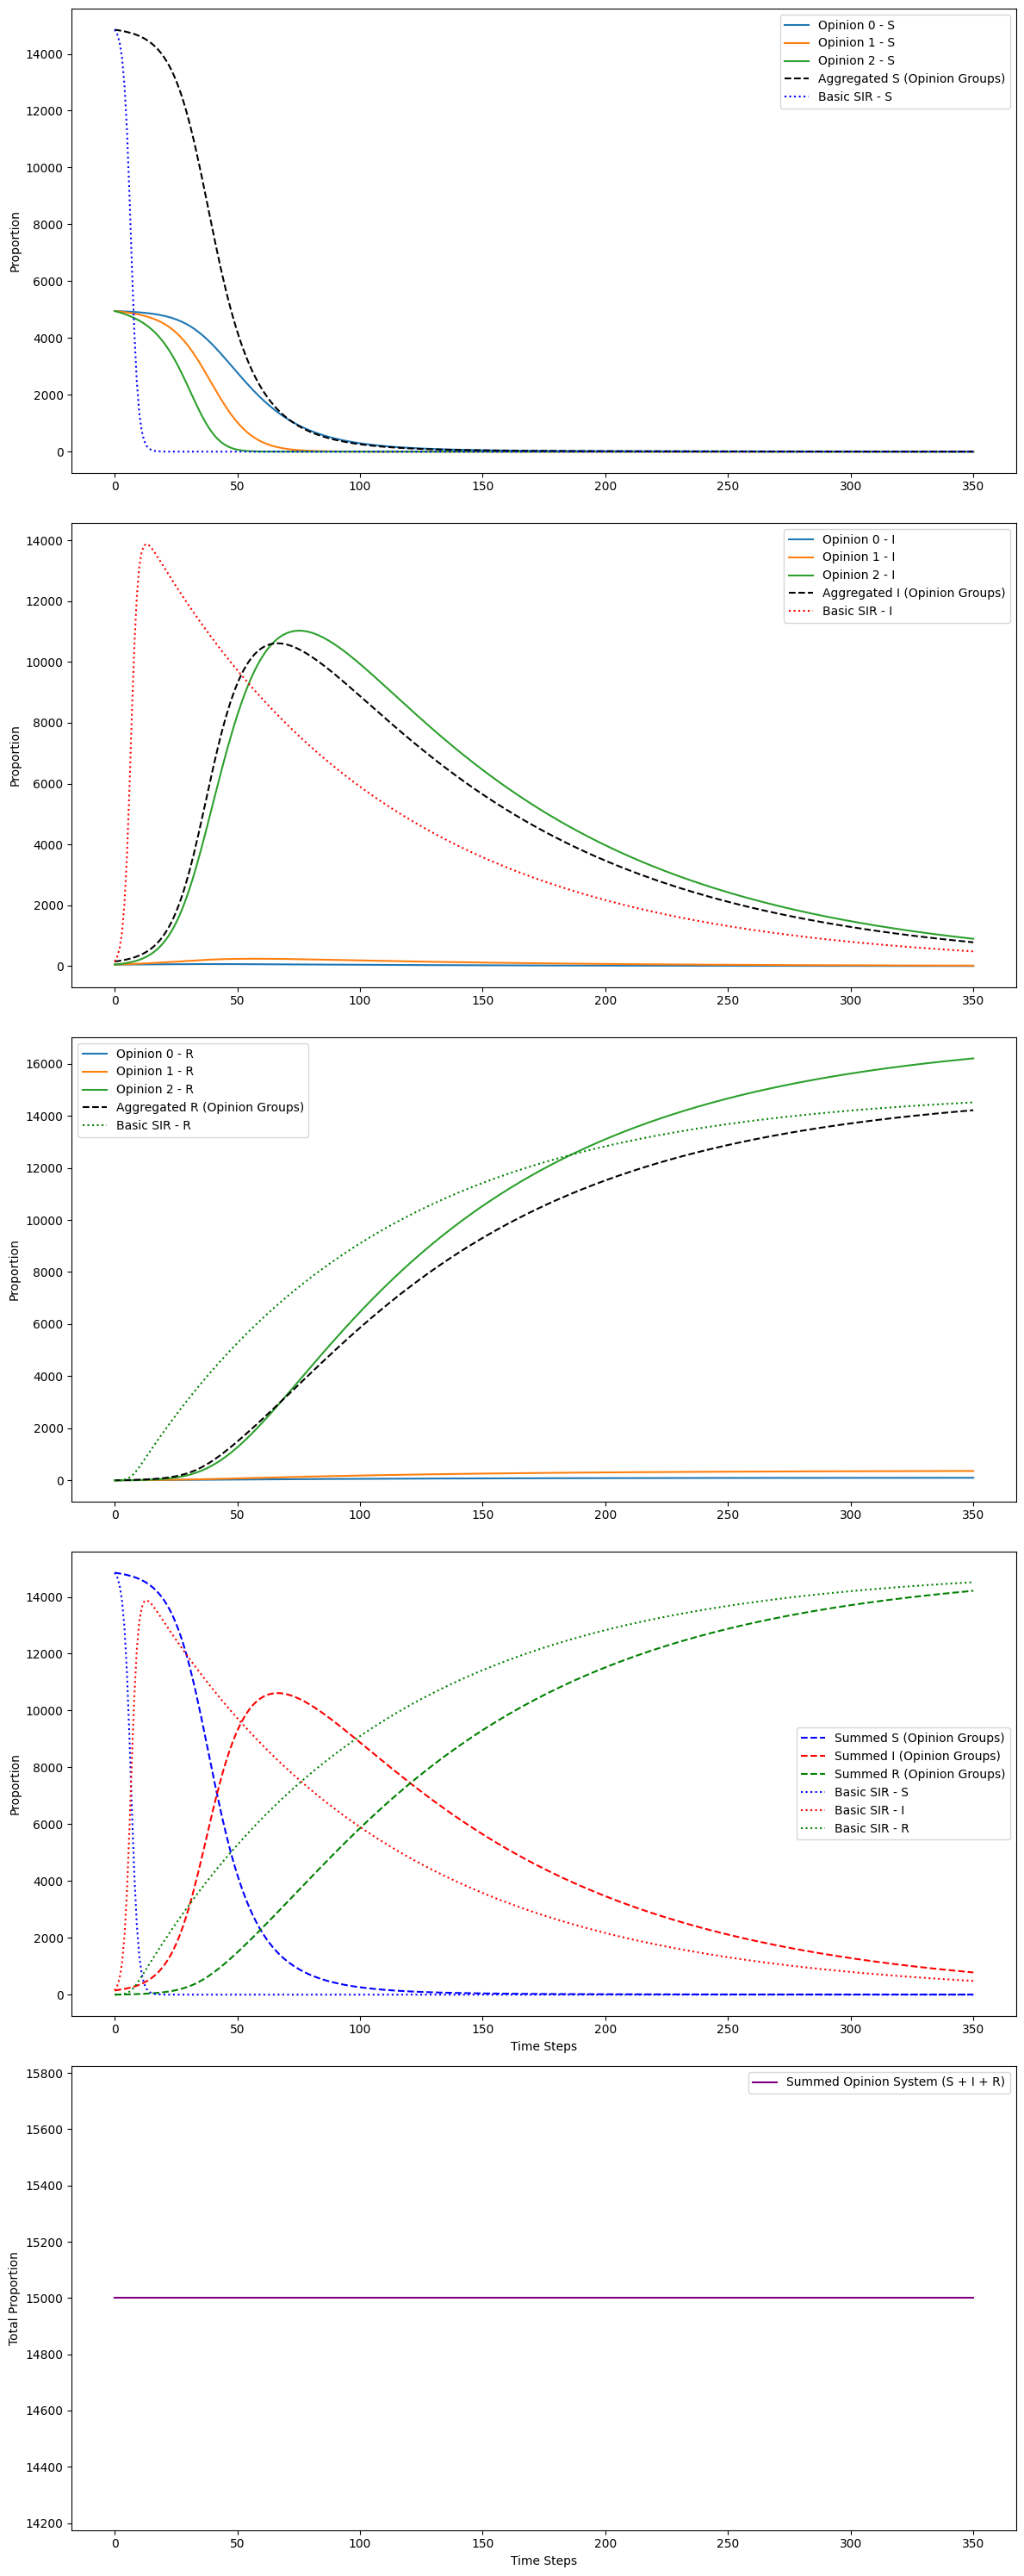

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.7
gamma = 0.01
MaxTime = 350
RunTime = np.linspace(0, MaxTime, MaxTime)

# Number of opinion groups (indexed from 0 to n)
n = 2  # The total number of opinion groups

# Probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Convert initial_values to a list
initial_conditions = [initial_values[f'P_S_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_I_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_R_{i}'] for i in range(n + 1)]

# Differential equations for the SIR model with opinions
def sir_opinion_system(y, t, N, beta, gamma, n):
    S = y[:n + 1]
    I = y[n + 1:2 * (n + 1)]
    R = y[2 * (n + 1):]
    
    dSdt = np.zeros(n + 1)
    dIdt = np.zeros(n + 1)
    dRdt = np.zeros(n + 1)
    
    for i in range(n + 1):
        dSdt[i] = -pi(i, n) * beta * S[i] * np.sum(I) / N
        dIdt[i] = pi(i, n) * beta * I[i] * np.sum(S) / (3 * N) - gamma * I[i]
        dRdt[i] = gamma * I[i]
    
    return np.concatenate([dSdt, dIdt, dRdt])

# Integrate the system of differential equations for the SIR model with opinions
result = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, beta, gamma, n))

# Extract S, I, R for each opinion group
S = result[:, :n + 1]
I = result[:, n + 1:2 * (n + 1)]
R = result[:, 2 * (n + 1):]

# Aggregate the opinion-based model values
aggregated_S = S.sum(axis=1)
aggregated_I = I.sum(axis=1)
aggregated_R = R.sum(axis=1)

# Normalize the summed opinion system so that it does not exceed N
aggregated_total = aggregated_S + aggregated_I + aggregated_R
normalizing_factor = N / aggregated_total
normalized_S = aggregated_S * normalizing_factor
normalized_I = aggregated_I * normalizing_factor
normalized_R = aggregated_R * normalizing_factor

# Sum of S, I, R values from the opinion groups model
summed_opinion_system = normalized_S + normalized_I + normalized_R

# Integrate the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Function to plot the simulation results
def plot_simulation_combined(normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n):
    fig, axes = plt.subplots(5, 1, figsize=(12, 30))

    # Plot S, I, R for each opinion group
    for i in range(n + 1):
        axes[0].plot(RunTime, S[:, i], label=f'Opinion {i} - S')
        axes[1].plot(RunTime, I[:, i], label=f'Opinion {i} - I')
        axes[2].plot(RunTime, R[:, i], label=f'Opinion {i} - R')

    # Plot aggregated opinion-based model values
    axes[0].plot(RunTime, normalized_S, label='Aggregated S (Opinion Groups)', color='black', linestyle='--')
    axes[1].plot(RunTime, normalized_I, label='Aggregated I (Opinion Groups)', color='black', linestyle='--')
    axes[2].plot(RunTime, normalized_R, label='Aggregated R (Opinion Groups)', color='black', linestyle='--')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Plot summed SIR proportions separately
    axes[3].plot(RunTime, normalized_S, label='Summed S (Opinion Groups)', color='blue', linestyle='--')
    axes[3].plot(RunTime, normalized_I, label='Summed I (Opinion Groups)', color='red', linestyle='--')
    axes[3].plot(RunTime, normalized_R, label='Summed R (Opinion Groups)', color='green', linestyle='--')
    axes[3].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[3].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[3].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    # Plot summed opinion system
    axes[4].plot(RunTime, summed_opinion_system, label='Summed Opinion System (S + I + R)', color='purple')
    axes[4].set_xlabel('Time Steps')
    axes[4].set_ylabel('Total Proportion')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

# Plot the results for both the basic SIR model and the opinion groups SIR model
plot_simulation_combined(normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n)


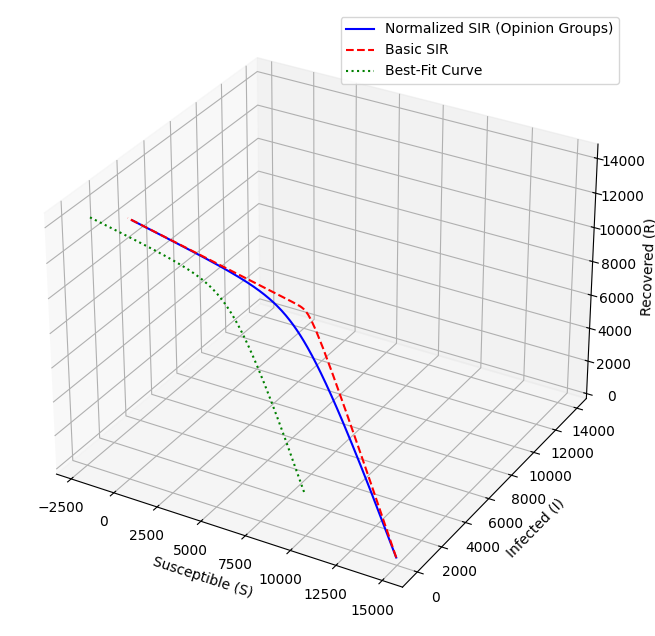

In [6]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the MSE function
def mse_function(params, normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R):
    a, b, c = params
    fitted_S = a * normalized_S + b
    fitted_I = a * normalized_I + c
    fitted_R = a * normalized_R + (1 - a - b - c)
    
    mse_S = np.mean((fitted_S - basic_S) ** 2)
    mse_I = np.mean((fitted_I - basic_I) ** 2)
    mse_R = np.mean((fitted_R - basic_R) ** 2)
    
    return mse_S + mse_I + mse_R

# Initial guess for the parameters
initial_guess = [1, 0, 0]

# Use an optimization method to minimize the MSE
result = minimize(mse_function, initial_guess, args=(normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R))

# Extract the best-fit parameters
best_fit_params = result.x

# Compute the best-fit SIR values
a, b, c = best_fit_params
fitted_S = a * normalized_S + b
fitted_I = a * normalized_I + c
fitted_R = a * normalized_R + (1 - a - b - c)

# Plot the 3D trajectory with the best-fit curve
def plot_3d_combined_with_fit(normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory in the SIR phase space for the opinion groups model
    ax.plot(normalized_S, normalized_I, normalized_R, label='Normalized SIR (Opinion Groups)', color='blue')
    
    # Plot the trajectory in the SIR phase space for the basic SIR model
    ax.plot(basic_S, basic_I, basic_R, label='Basic SIR', color='red', linestyle='--')
    
    # Plot the best-fit curve
    ax.plot(fitted_S, fitted_I, fitted_R, label='Best-Fit Curve', color='green', linestyle=':')
    
    # Label the axes
    ax.set_xlabel('Susceptible (S)')
    ax.set_ylabel('Infected (I)')
    ax.set_zlabel('Recovered (R)')
    
    ax.legend()
    plt.show()

# Call the plotting function
plot_3d_combined_with_fit(normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R)
